# Continuous Log-Gassian-Cox-Process with Weather
This notebook contains the code for the problem in continuous space instead of grid-space incorperating weather data.

### Theory

**1 Model Formulation**

We model accident locations $\{x_i\}_{i=1}^N\subset\mathcal{D}\subset\mathbb{R}^2$ as an **inhomogeneous Poisson point process** with intensity

$$
\lambda(x)\;=\;\exp\bigl(f(x)+\beta w(x)\bigr)\,,
$$

where the latent function $f:\mathcal D\to\mathbb R$ is given a **Gaussian process (GP) prior**

$$
f(\,\cdot\,)\sim\mathcal{GP}\bigl(0,\,k(\,\cdot\,,\,\cdot\,)\bigr)\,,
$$

and $k(x,x')$ is a positive-definite covariance kernel (e.g. RBF, Matérn, etc.).  The exponential ensures $\lambda(x)>0$ everywhere.

The $w(x)$ term represents the weather associated with the accident, with data on precipitation, temperature, humidity, wind speed, and solar radiation. (w is more of a function of time than of space though, maybe it shouldn't accept x?). $\beta$ is the vector of parameters associated with the different weather attributes.

**2 Poisson-Process Likelihood**

Given $\{x_i\}$, the log-likelihood under intensity $\lambda$ is

$$
\log p\bigl(\{x_i\}\mid f\bigr)
=\sum_{i=1}^N\log\lambda(x_i)\;-\;\int_{\mathcal D}\lambda(x)\,dx
=\sum_{i=1}^N f(x_i)+\beta w(x)_i\;-\;\int_{\mathcal D} e^{f(x)+\beta w(x)}\,dx\,.
$$

The first term “counts” the log-intensity at observed points; the second subtracts the total mass.

**3 Monte Carlo Quadrature of the Integral**

The integral $\int_{\mathcal D}e^{f(x)+\beta w(x)}dx$ is intractable.  We approximate it by

$$
\int_{\mathcal D}e^{f(x)+\beta w(x)}dx
\;\approx\;\frac{\mathrm{Area}(\mathcal D)}{M}
\sum_{j=1}^M e^{f(u_j)+\beta w(u_j)}\,,
$$

where $\{u_j\}$ are $M$ points sampled uniformly in $\mathcal D$.  As $M\to\infty$ this Monte Carlo estimator is unbiased and consistent.

**4 Finite-Dimensional GP Prior**

We only ever need $f$ evaluated at the $N$ observed locations and the $M$ quadrature points.  Denote

$$
X_{\rm obs} = \{x_i\}_{i=1}^N,\quad
X_{\rm quad}=\{u_j\}_{j=1}^M,\quad
X_{\rm all}=[X_{\rm obs},X_{\rm quad}]\in\mathbb R^{(N+M)\times 2}\,.
$$

Under the GP prior,

$$
\mathbf f_{\rm all} = \bigl[f(x_1),\dots,f(x_N),\,f(u_1),\dots,f(u_M)\bigr]^\top
\sim\mathcal N\bigl(\mathbf0,\;K\bigr),
$$

where $K_{ij}=k\bigl(X_{\rm all,i},X_{\rm all,j}\bigr)$.  We add a small “jitter” or noise variance on the diagonal to ensure numerical stability in the Cholesky decomposition.

# Ok, so I haven't update the following steps to include $\beta w(x)$ yet, but basically, anywhere you see f you should also see $\beta w(x)$

**5 Joint Log-Probability**

Combining prior and likelihood gives the complete-data log-density up to a constant:

$$
\begin{aligned}
\log p\bigl(\mathbf f_{\rm all},\{x_i\}\bigr)
&=\underbrace{-\tfrac12\,\mathbf f_{\rm all}^\top K^{-1}\,\mathbf f_{\rm all}
-\tfrac12\log|K|}_{\log p(\mathbf f_{\rm all})}
\;+\;\sum_{i=1}^N f(x_i)\;-\;\frac{\mathrm{Area}}{M}\sum_{j=1}^M e^{f(u_j)}.
\end{aligned}
$$

In Pyro we realize this by

* sampling $\mathbf f_{\rm all}\sim\mathcal N(0,K)$ via a `pyro.sample("f_all", …​)`,
* then emitting the likelihood terms as two `pyro.factor` calls inside plates of size $N$ and $M$.

**6 Variational Inference (SVI)**

Exact posterior $p(\mathbf f_{\rm all}\mid\{x_i\})$ is intractable because of the non-Gaussian Poisson likelihood.  We introduce a **variational distribution** $q(\mathbf f_{\rm all})$ (e.g. mean‐field Normal or an AutoGuide) and maximize the **Evidence Lower Bound (ELBO)**:

$$
\mathcal{L}=\mathbb{E}_{q}\Bigl[\log p(\mathbf f_{\rm all},\{x_i\}) - \log q(\mathbf f_{\rm all})\Bigr].
$$

Optimizing $\mathcal{L}$ w.r.t. both guide parameters (variational means/covariances) and model parameters (kernel hyper-priors or point-estimates) gives an approximate posterior. Pyro’s SVI uses stochastic gradient ascent with Monte Carlo estimates of the ELBO gradients.

**7 Why It Works**

1. **Spatial correlation**: the GP prior $k(\cdot,\cdot)$ enforces that nearby locations have similar intensities, capturing clustering or smooth gradients in accident risk.
2. **Non-Gaussian likelihood**: the exponential link and Poisson‐process likelihood directly model the fact that accidents are discrete random events in continuous space.
3. **Tractable approximation**:

   * Monte Carlo quadrature reduces the continuous integral to a finite sum, unbiased in expectation.
   * Variational inference with SVI scales to thousands of points by trading exact posterior for a fast, vectorized optimization.
4. **Automatic differentiation**: all steps (cholesky, exponentials, sums) are differentiable, so gradients flow from the ELBO back to kernel hyper-parameters and guide parameters.


### Code

In [62]:
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
from torch.linalg import cholesky
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.contrib.gp.kernels import RBF, Matern32, RationalQuadratic
import pandas as pd
import geopandas as gpd
import torch
import pyro
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

Prepare data

In [72]:
#here I pasted the path in my computer to the shared folder
path_to_shared_folder = "/Users/asherkite/Desktop/School/Courses/MBML/MBML_Project/MBML_github/MBML-traffic-accidents/"
#accident dataframe
df = pd.read_csv(path_to_shared_folder+'data/df_hourly_january.csv', parse_dates=['datetime'])
df["datetime"] =  pd.to_datetime(df['datetime'])
df.set_index(['datetime', 'cell_id'], inplace=True)
#weather dataframe for all of 2023. Since there is only accident data for january, the extra time is filter out later
weather23 = pd.read_csv(path_to_shared_folder+"data/2023_Weather.csv")
weather23.rename(columns={"Time":"datetime"},inplace=True)
weather23["datetime"] =  pd.to_datetime(weather23['datetime'])
weather23.drop(columns="Unnamed: 0",inplace=True)
weather23


,datetime,acc_precip,mean_temp,mean_relative_hum,mean_wind_speed,mean_radiation
0,2023-01-01 00:00:00,1.1,9.1,99.0,1.6,0.0
1,2023-01-01 01:00:00,3.5,9.0,99.3,1.7,0.0
2,2023-01-01 02:00:00,0.9,9.8,99.5,2.9,0.0
3,2023-01-01 03:00:00,2.3,10.7,98.3,5.4,0.0
4,2023-01-01 04:00:00,0.7,10.6,98.0,5.3,0.0
...,...,...,...,...,...,...
8755,2023-12-31 19:00:00,0.3,4.8,93.5,7.0,0.0
8756,2023-12-31 20:00:00,1.2,4.7,95.0,6.9,0.0
8757,2023-12-31 21:00:00,1.6,4.8,95.7,6.0,0.0
8758,2023-12-31 22:00:00,2.7,4.9,96.0,5.5,0.0


In [120]:

#Here we combine the datasets into one
df_reset = df.reset_index()
merged1 = pd.merge(weather23, df_reset, on='datetime')
# Set back the original multiindex
merged1["mean_temp"] = merged1["mean_temp"]+273.15
merged1 = merged1.set_index(['cell_id', 'datetime'])
merged1


,,acc_precip,mean_temp,mean_relative_hum,mean_wind_speed,mean_radiation,acc_count,X,Y
cell_id,datetime,,,,,,,,
"(720517.001, 6172015.001)",2023-01-01 00:00:00,1.1,282.25,99.0,1.6,0.0,0,NaN,NaN
"(720517.001, 6172515.001)",2023-01-01 00:00:00,1.1,282.25,99.0,1.6,0.0,0,NaN,NaN
"(720517.001, 6173015.001)",2023-01-01 00:00:00,1.1,282.25,99.0,1.6,0.0,0,NaN,NaN
"(720517.001, 6173515.001)",2023-01-01 00:00:00,1.1,282.25,99.0,1.6,0.0,0,NaN,NaN
"(720517.001, 6174015.001)",2023-01-01 00:00:00,1.1,282.25,99.0,1.6,0.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
"(727017.001, 6175015.001)",2023-01-31 23:00:00,0.0,277.15,81.3,7.4,0.0,0,NaN,NaN
"(727017.001, 6175515.001)",2023-01-31 23:00:00,0.0,277.15,81.3,7.4,0.0,0,NaN,NaN
"(727017.001, 6176015.001)",2023-01-31 23:00:00,0.0,277.15,81.3,7.4,0.0,0,NaN,NaN


In [121]:

#drop all rows with no X and Y data (IE, rows without accidents.)
#since we only use accident data for january, this also drops all months BESIDES for january
merged2 = merged1[merged1['X'].notna()].reset_index(drop=True)
if merged2["Y"].isna().any():
    print("Warning: NaNs found in Y column.")
    raise ValueError("Each observed accident must have coordinates. An accident was found with no Y coordinate.")
merged2

,acc_precip,mean_temp,mean_relative_hum,mean_wind_speed,mean_radiation,acc_count,X,Y
0,3.5,282.15,99.3,1.7,0.0,1,722486.694,6174248.234
1,0.6,280.45,99.2,2.0,0.0,1,725696.001,6172194.001
2,0.6,280.45,99.2,2.0,0.0,1,725480.428,6175703.304
3,0.3,282.95,99.0,3.8,12.0,1,723337.001,6178326.001
4,0.1,282.45,96.2,5.1,9.0,1,725598.232,6177460.554
...,...,...,...,...,...,...,...,...
104,0.0,276.55,68.3,6.8,0.0,1,721998.280,6178558.317
105,0.0,274.95,85.0,3.7,0.0,1,726466.742,6174562.202
106,0.8,277.35,98.0,3.7,46.0,1,724296.440,6176788.883
107,0.1,278.55,96.7,5.6,66.0,1,723749.973,6174143.985


In [122]:
df_day = merged2.copy()

# Convert UTM (metres) to kilometres for nicer kernel length‑scale priors
# coords: accident locations in km after centering, shape (N,2)
coords = df_day[["X", "Y"]].values / 1_000.0  # shape (n_points, 2)

# Re‑centre so the south‑west corner is (0,0) and make it a tensor
coords = coords - coords.min(0, keepdims=True)
coords = torch.Tensor(coords).detach().clone()

# Define M quadrature points uniformly over the bounding box of coords
N, _ = coords.shape
M = 1000  # Numper of samples 

# Compute bounding‐box mins and ranges as tensors
x_min, y_min = coords.min(0).values          # both floats
x_max, y_max = coords.max(0).values          # both floats
mins   = torch.tensor([x_min, y_min])        # shape (2,)
ranges = torch.tensor([x_max - x_min,
                       y_max - y_min])      # shape (2,)

# Draw M uniform points in [0,1]^2, then scale & shift
U = torch.rand(M, 2) * ranges[None, :] + mins[None, :]  # shape (M,2)

# Compute domain area in km² for the bounding box
area = (x_max - x_min) * (y_max - y_min)

# Pre-stack all locations for the GP: first the observed points, then quadrature
X_all = torch.cat([coords, U], dim=0)  # shape (N+M, 2)

In [124]:
#here you can put the specific weather you want to test #maybe we should use Kelvin?
precip = 0
temp = 0
hum = 0
wind = 0
radiation = 0

weather_obs = torch.tensor(
    merged2[["acc_precip", "mean_temp", "mean_relative_hum", "mean_wind_speed", "mean_radiation"]].values,
    dtype=torch.float
)

weather_query = torch.tensor([precip, temp, hum, wind, radiation])
weather_quad = weather_query.expand(M, 5)

Define model

In [125]:
class LogGaussianCoxProcess():
    def __init__(self, kernel_cls, input_dim=2):
        self.kernel = kernel_cls(input_dim=input_dim)

    def model(self, coords, U, area, weather_obs,weather_quad):
        """
        coords:   (N,2) tensor of observed accident locations
        U:        (M,2) tensor of quadrature locations (inside study area)
        area:     float, total area of study region
        """
        weather_obs = weather_obs.to(dtype=torch.float)
        weather_quad = weather_quad.to(dtype=torch.float)
        N = coords.shape[0]
        M = U.shape[0]
        D = weather_obs.shape[1]
        #expand in pyro?
        beta = pyro.sample("beta", dist.Normal(0., 1.).expand([D]).to_event(1))  # shape (D,) IE, 5 since we have 5 types of weather data
        
        # Sample kernel hyper‐parameters (priors), and set them in the kernel
        ls    = pyro.sample("ls", dist.LogNormal(0., 0.5))
        var   = pyro.sample("var",    dist.LogNormal(0., 1.0))
        noise = pyro.sample("noise",       dist.LogNormal(-3., 0.3))
        self.kernel.lengthscale = ls
        self.kernel.variance    = var

        # Build full covariance over all points
        X_all = torch.cat([coords, U], dim=0)       # shape (N+M, 2)
        K = self.kernel(X_all)        
        K = 0.5*(K + K.T)                            # enforce symmetry
        K = K + (noise + 1e-4) * torch.eye(N+M)     # jitter + noise
        L = cholesky(K)                             # lower‐Cholesky

        # Sample the latent GP at all points
        f_all = pyro.sample(
            "f_all",
            dist.MultivariateNormal(
                loc=torch.zeros(N+M),
                scale_tril=L
            )
        )

        # Split into observed vs quadrature
        f_obs  = f_all[:N]      # latent at each accident
        f_quad = f_all[N:]      # latent at each quadrature site
        f_obs = f_obs + (weather_obs @ beta)      # shape (N,)
        f_quad = f_quad + (weather_quad @ beta)   # shape (M,)

        # Log‐likelihood via Monte‐Carlo quadrature, 
        with pyro.plate("obs", N):
            # each observed point contributes +f(x_i) to the log‐likelihood
            pyro.factor("obs_ll", f_obs)

        with pyro.plate("quad", M):
            # each quadrature point contributes −(area/M) * exp(f(u_j))
            pyro.factor("quad_ll", - (area / M) * torch.exp(f_quad))

Run inference with SVI/MCMC

In [126]:
# List of kernels to compare
kernel_constructors = {
    "RBF": RBF,
    "RationalQuadratic": RationalQuadratic,
}

results = []

for name, Kclass in kernel_constructors.items():
    print(f"\n=== Kernel: {name} ===")
    model = LogGaussianCoxProcess(Kclass).model
    guide = AutoDiagonalNormal(model)
    

    pyro.clear_param_store()
    #specifics of SVI function?
    svi = SVI(model, guide, ClippedAdam({"lr":1e-2}), Trace_ELBO())
    # run SVI
    for step in range(1000):
        """if step % 100 == 0:
            print(f"[step {step:4d}]  ELBO = {-svi.step(coords, U, area,weather_obs,weather_quad):.2f}")
        svi.step(coords, U, area, weather_obs,weather_quad)"""
        loss = svi.step(coords, U, area, weather_obs, weather_quad)
        if step % 100 == 0:
            print(f"[step {step:4d}]  ELBO = {-loss:.2f}")
    elbo = -loss  # final ELBO estimate

    results.append({"kernel": name, "ELBO": elbo, "model": model, "guide": guide})

df_result = pd.DataFrame(results).set_index("kernel")


=== Kernel: RBF ===
[step    0]  ELBO = -16174.30
[step  100]  ELBO = 27375.38
[step  200]  ELBO = 70558.68
[step  300]  ELBO = 115872.53
[step  400]  ELBO = 159242.90
[step  500]  ELBO = 202465.84
[step  600]  ELBO = 245645.58
[step  700]  ELBO = 287210.52
[step  800]  ELBO = 326344.86
[step  900]  ELBO = 370158.44

=== Kernel: RationalQuadratic ===
[step    0]  ELBO = 18557.39
[step  100]  ELBO = 55782.45
[step  200]  ELBO = 107682.21
[step  300]  ELBO = 145219.79
[step  400]  ELBO = 188863.40
[step  500]  ELBO = 232737.04
[step  600]  ELBO = 274435.03
[step  700]  ELBO = 317405.23
[step  800]  ELBO = 362254.30
[step  900]  ELBO = 408205.46


Analyse results

/var/folders/h6/d2ttd9q92dqcvwk3_r7sjb180000gn/T/ipykernel_14113/2132304428.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  abs_U_km    = U + offset_km                            # (M,2) in km


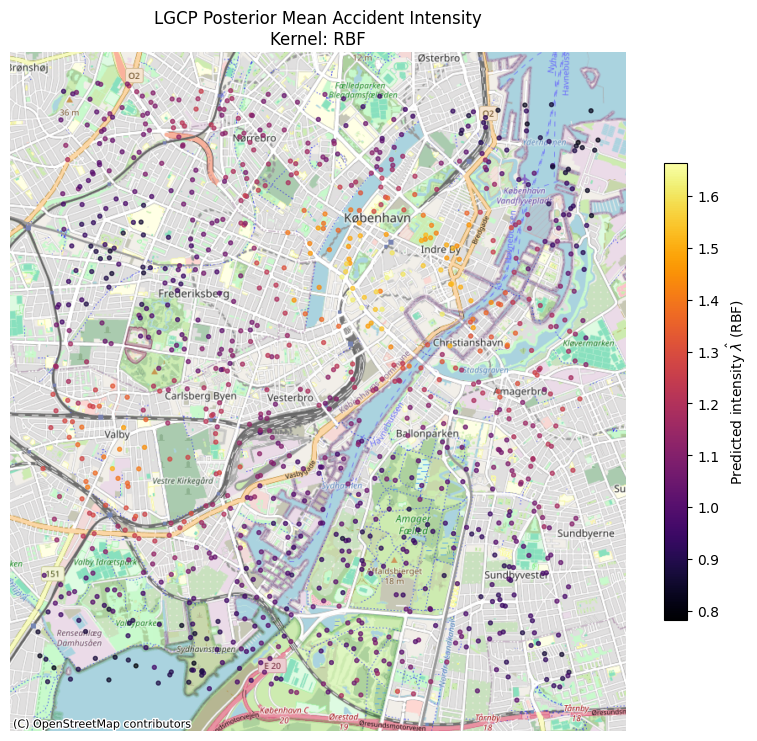

ls: mean=1.269, sd=0.819
var: mean=1.894, sd=2.590
noise: mean=0.088, sd=0.004


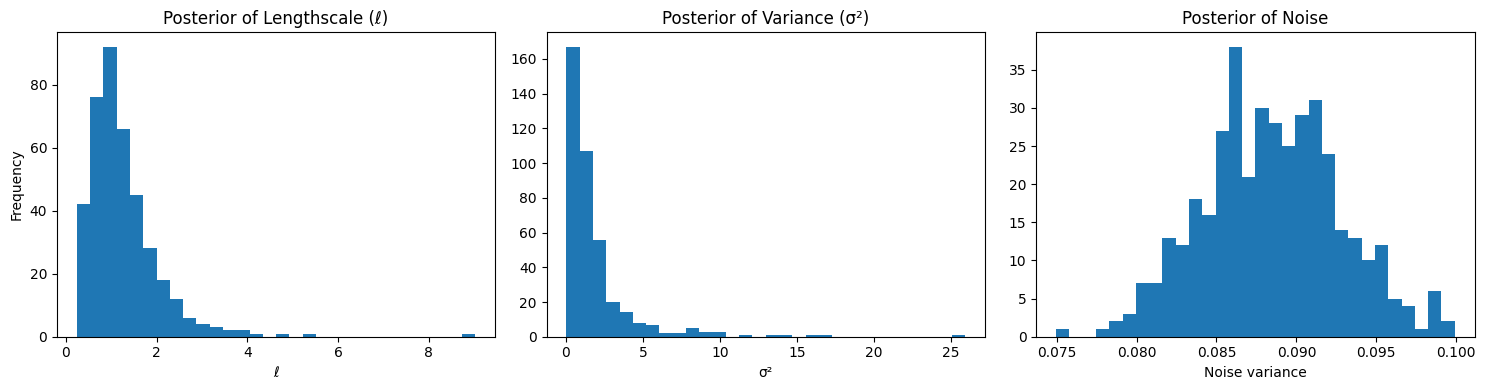

beta mean: [10.575867  9.52779   9.921653 10.047943 10.023199]
beta std: [0.79144496 0.072931   0.15627222 0.15097958 0.08702054]
β[0] = 10.576 ± 0.791
β[1] = 9.528 ± 0.073
β[2] = 9.922 ± 0.156
β[3] = 10.048 ± 0.151
β[4] = 10.023 ± 0.087


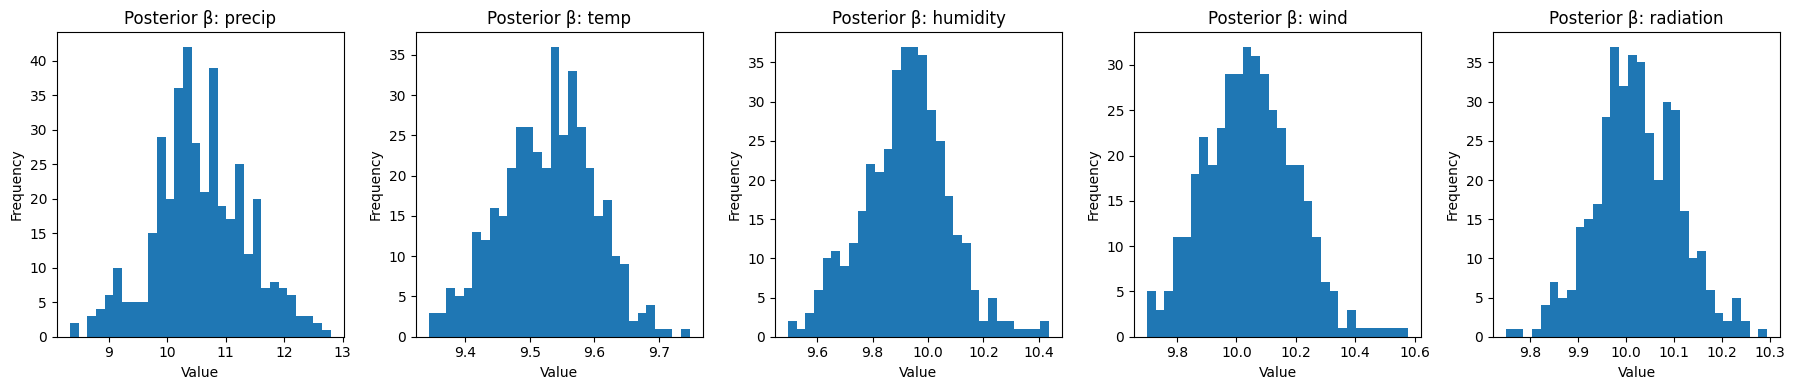

/var/folders/h6/d2ttd9q92dqcvwk3_r7sjb180000gn/T/ipykernel_14113/2132304428.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  abs_U_km    = U + offset_km                            # (M,2) in km


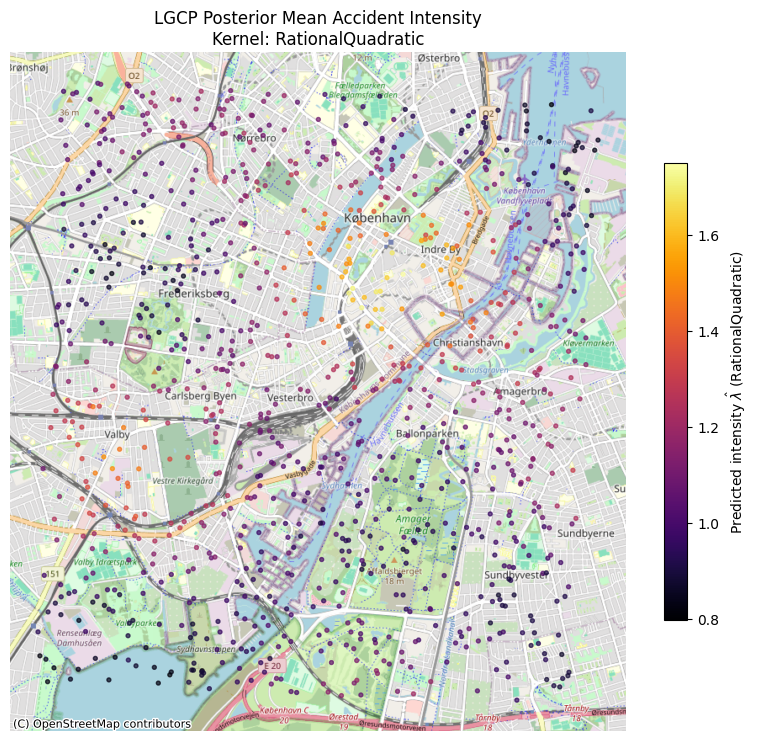

ls: mean=1.232, sd=0.666
var: mean=1.973, sd=4.763
noise: mean=0.091, sd=0.004


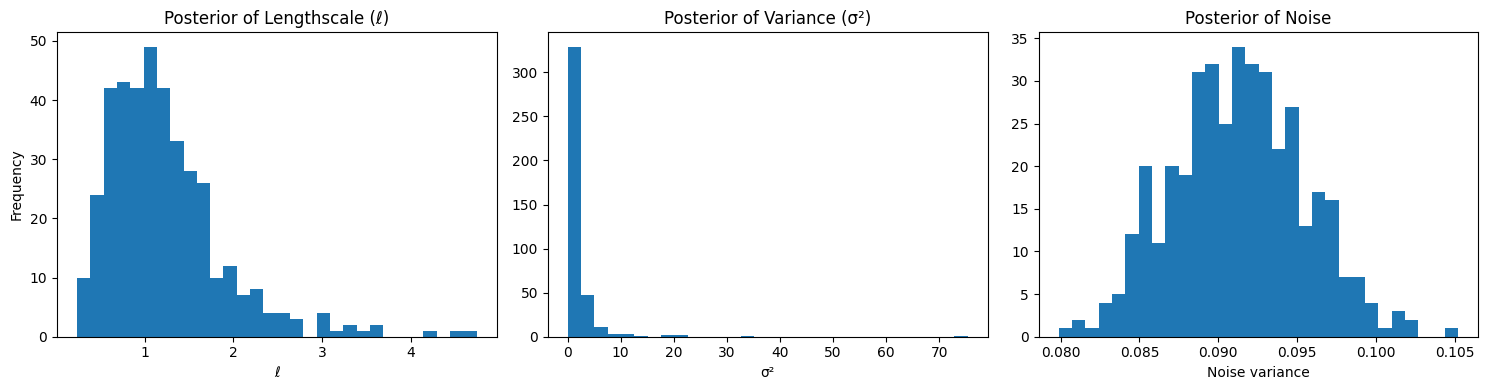

beta mean: [10.263775 10.520902 10.062744 10.400485 10.19079 ]
beta std: [0.771797   0.07368129 0.15619546 0.1540614  0.08307654]
β[0] = 10.264 ± 0.772
β[1] = 10.521 ± 0.074
β[2] = 10.063 ± 0.156
β[3] = 10.400 ± 0.154
β[4] = 10.191 ± 0.083


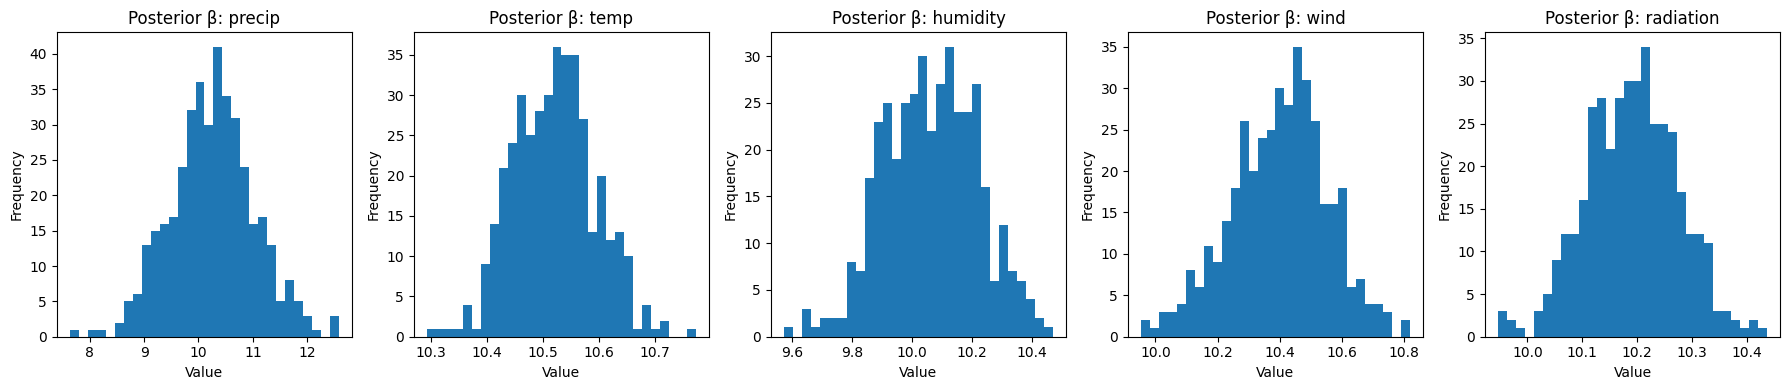

In [127]:
for name, row in df_result.iterrows():
    model = row['model']
    guide = row['guide']

    # Draw samples from the variational posterior
    predictive = Predictive(model, guide=guide, num_samples=400)
    samples    = predictive(coords, U, area,weather_obs,weather_quad)
    
    # Monte Carlo posterior mean of f_all
    f_all_post = samples["f_all"].mean(0).squeeze()   # shape (N+M,)
    
    # Slice into obs vs quad
    N = coords.size(0)
    f_quad_mean = f_all_post[N:] # shape (M,)
    
    # Compute intensities at quadrature points
    lambda_quad = torch.exp(f_quad_mean)    # shape (M,)
    
    # Compute original UTM shift
    coords_orig = df_day[["X","Y"]].dropna().values / 1000.0  # km
    offset_km   = coords_orig.min(axis=0)                  # (x_min, y_min) in km
    abs_U_km    = U + offset_km                            # (M,2) in km
    abs_U_m     = abs_U_km * 1000.0                        # (M,2) in metres

    # Build GeoDataFrame
    df_plot = gpd.GeoDataFrame(
        {"intensity": lambda_quad.numpy()},
        geometry=[Point(x, y) for x, y in abs_U_m.numpy()],
        crs="EPSG:25832"
    )
    gdf_web = df_plot.to_crs(epsg=3857)

    # Plot on map
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf_web.plot(
        column="intensity",
        ax=ax,
        markersize=8,
        alpha=0.7,
        cmap="inferno",
        legend=True,
        legend_kwds={"label": f'Predicted intensity $\\hat\\lambda$ ({name})', "shrink":0.6}
    )
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()
    ax.set_title(f"LGCP Posterior Mean Accident Intensity\nKernel: {name}")
    plt.tight_layout()
    plt.show()

    # Summary hyperparameters
    for name in ["ls","var","noise"]:
        vals = samples[name]
        print(f"{name}: mean={vals.mean():.3f}, sd={vals.std():.3f}")

    # Plot hyperparameter posteriors
    ls_samples = samples["ls"].detach().cpu().numpy()
    var_samples = samples["var"].detach().cpu().numpy()
    noise_samples = samples["noise"].detach().cpu().numpy()

    # Plot histograms
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].hist(ls_samples, bins=30)
    axes[0].set_title("Posterior of Lengthscale (ℓ)")
    axes[0].set_xlabel("ℓ")
    axes[0].set_ylabel("Frequency")

    axes[1].hist(var_samples, bins=30)
    axes[1].set_title("Posterior of Variance (σ²)")
    axes[1].set_xlabel("σ²")

    axes[2].hist(noise_samples, bins=30)
    axes[2].set_title("Posterior of Noise")
    axes[2].set_xlabel("Noise variance")

    plt.tight_layout()
    plt.show()

    beta_samples = samples["beta"].detach().cpu().numpy()

    mean_beta = beta_samples.mean(axis=0).flatten()
    std_beta = beta_samples.std(axis=0).flatten()
    print("beta mean:",mean_beta)
    print("beta std:", std_beta)

    for i, (mean, std) in enumerate(zip(mean_beta, std_beta)):
        print(f"β[{i}] = {mean.item():.3f} ± {std.item():.3f}")

    #print("beta samples shape:", beta_samples.shape)
    beta_samples = beta_samples.squeeze(1)  # shape becomes (400, 5)
    #print("beta samples shape:", beta_samples.shape)

    fig, ax = plt.subplots(1, beta_samples.shape[1], figsize=(18, 4))
    weather_names = ["precip", "temp", "humidity", "wind", "radiation"]

    for i in range(beta_samples.shape[1]):
        ax[i].hist(beta_samples[:, i], bins=30)
        ax[i].set_title(f"Posterior β: {weather_names[i]}")
        ax[i].set_xlabel("Value")
        ax[i].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()
